# Importaciones

In [1]:
!pip install -U spacy
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 50.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import re
import nltk
import spacy
import numpy as np
import pandas as pd
import pickle as pk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words_es = set(stopwords.words('spanish'))
nlp = spacy.load("es_core_news_sm")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Carga conjuntos de datos

In [4]:
# Cargar el archivo CSV
df_task1 = pd.read_csv("dataset_task1_augmented.csv")
df_task2 = pd.read_csv("dataset_task2_extended.csv")

# Eliminar valores nulos y duplicados
df_task1 = df_task1.dropna().drop_duplicates()
df_task2 = df_task2.dropna().drop_duplicates()

# Sin []
df_task1["lyrics_clean"] = df_task1["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_task2["lyrics_clean"] = df_task2["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

In [5]:
df_task1.head()

,Unnamed: 0,id,lyrics,label,lyrics_clean
0,0,T1_TRAIN_0001,"\n[Letra de ""No Me Enseñaste""]\n\n[Verso 1]\nL...",0,Llama no importa la hora que yo estoy aquí Ent...
1,1,T1_TRAIN_0003,"n\nTe amare toda la vida\nTodos los años, los ...",0,"n Te amare toda la vida Todos los años, los me..."
2,2,T1_TRAIN_0007,\nQuieres saber\nSi todavía te sigo pensando\n...,0,Quieres saber Si todavía te sigo pensando Quie...
3,3,T1_TRAIN_0008,\nNo quiero separarme de ti\nNi siquiera un mo...,0,No quiero separarme de ti Ni siquiera un momen...
4,4,T1_TRAIN_0009,"o\nVamo'a ver si es verdad\nQue tú sirves, Car...",0,"o Vamo'a ver si es verdad Que tú sirves, Carid..."


In [6]:
df_task2.head()

,Unnamed: 0,id,lyrics,label,lyrics_clean
0,0,T2_TRAIN_0001,".\nQue no me falte tu cuerpo jamás, jamás\nNi ...",0,". Que no me falte tu cuerpo jamás, jamás Ni el..."
1,1,T2_TRAIN_0002,"\n[Letra de ""Que Te Vaya Bonito""]\n\n[Verso 1]...",0,Ojalá que te vaya bonito Ojalá que se acaben t...
2,2,T2_TRAIN_0003,\n[Coro:]\nAy me canse de rogarle (yo ah)\nAy ...,3,Ay me canse de rogarle (yo ah) Ay me canse de ...
3,3,T2_TRAIN_0004,"\n[Letra de ""Te Conozco""]\n\n[Verso 1]\nTe con...",1,Te conozco desde el pelo hasta la punta de los...
4,4,T2_TRAIN_0005,Letra subida por enriquembu\n\nSoy un hombre d...,0,Letra subida por enriquembu Soy un hombre dive...


# Pipeline tokenización

In [7]:
# Función para limpiar y lematizar texto en español
def limpiar_texto(texto):
    texto = texto.lower()  # Minúsculas
    texto = re.sub(r'\d+', '', texto)  # Eliminar números
    texto = re.sub(r'[^\w\s]', '', texto)  # Eliminar puntuación
    palabras = word_tokenize(texto)  # Tokenización

    # Eliminar stopwords en español
    palabras = [p for p in palabras if p not in stop_words_es]

    # Lematización con spaCy
    doc = nlp(" ".join(palabras))
    palabras = [token.lemma_ for token in doc]

    return ' '.join(palabras)

df_task1['tokens'] = df_task1['lyrics_clean'].astype(str).apply(limpiar_texto)
df_task2['tokens'] = df_task2['lyrics_clean'].astype(str).apply(limpiar_texto)

# Clasificación Binaria (Task 1) (SVM)

## TD-IDF

### Entrenamiento

In [8]:
X = df_task1['tokens']
y = df_task1['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [9]:
# Pipeline: TF-IDF seguido de SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['auto'],  # solo aplica si kernel='rbf'
    'svm__class_weight': ['balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)

# Entrenar con datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo ya entrenado
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros: {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 'auto', 'svm__kernel': 'linear', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [10]:
# Guardar el modelo en un archivo
with open('model_SVM_TD-IDF_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [11]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7964176496286588


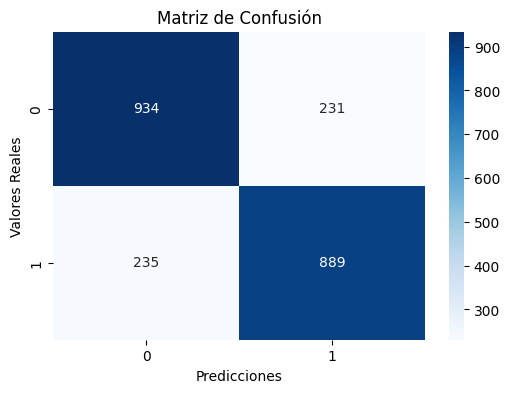

In [12]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

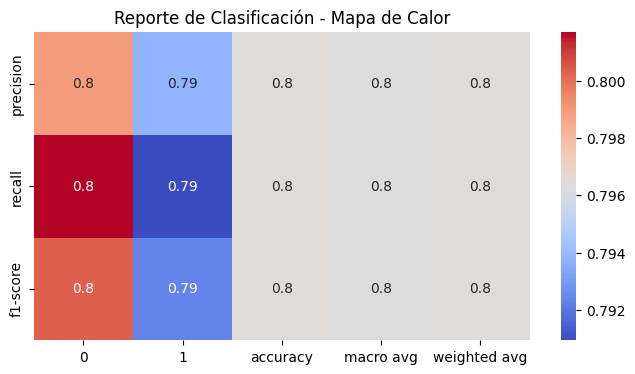

In [13]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [14]:
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [15]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,282
M,245


In [16]:
df_results.to_csv('results_SVM_TD-IDF_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,M
2,T1_TEST_0003,NM
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


## Sentence-Embeddings

In [17]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Entrenamiento

In [18]:
# Generar embeddings para cada texto
lyrics = df_task1['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task1['label']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/358 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [19]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Más valores para encontrar el mejor
    'kernel': ['linear', 'rbf'],  # Diferentes transformaciones
    'gamma': ['auto'],
    'class_weight': ['balanced']  # Para manejar clases desbalanceadas
}

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}


In [20]:
# Guardar el modelo en un archivo
with open('model_SVM_Sentence_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [21]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.780690257754478


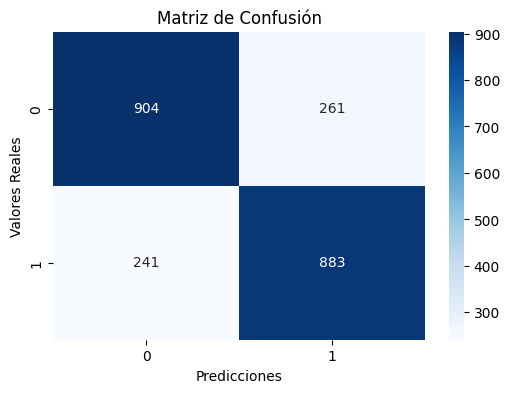

In [22]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

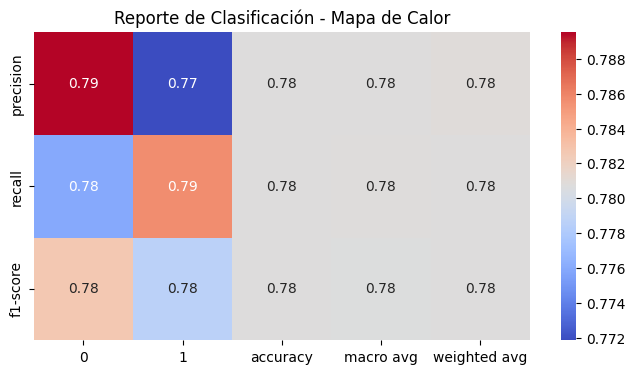

In [23]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [24]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [25]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,527


In [26]:
df_results.to_csv('results_SVM_Sentence_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,NM
2,T1_TEST_0003,NM
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


# Clasificación Multiclase (Task 2) (SVM)

## TD-IDF

### Entrenamiento

In [27]:
X = df_task2['tokens']
y = df_task2['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [28]:
# Pipeline: TF-IDF seguido de SVM
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', SVC(random_state=42))
])

# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'svm__C': [0.01, 0.1, 1, 10, 100],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['auto'],  # solo aplica si kernel='rbf'
    'svm__class_weight': ['balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)

# Entrenar con datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)

# Obtener el mejor modelo ya entrenado
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Mejores hiperparámetros: {'svm__C': 1, 'svm__class_weight': 'balanced', 'svm__gamma': 'auto', 'svm__kernel': 'linear', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [29]:
# Guardar el modelo en un archivo
with open('model_SVM_TD-IDF_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [30]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7115384615384616


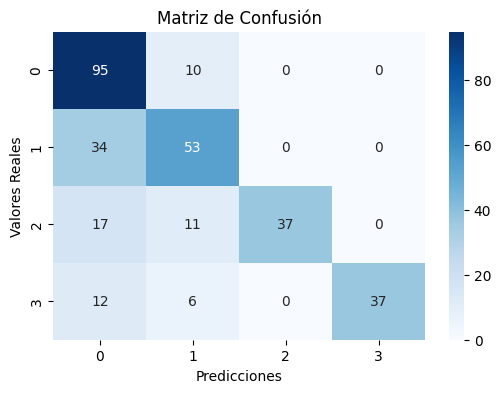

In [31]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

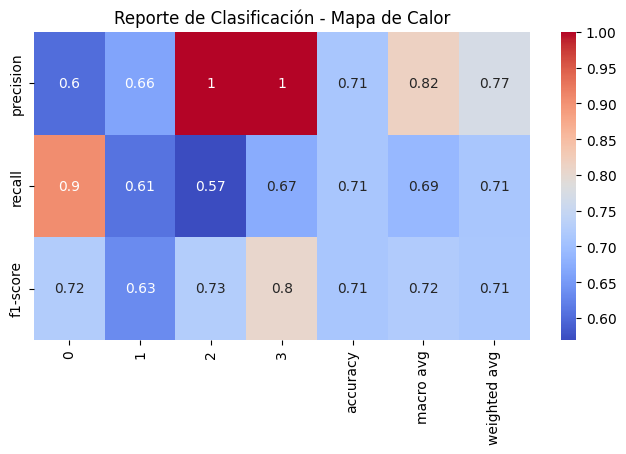

In [32]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [33]:
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [34]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,146
S,74
H,37
V,36


In [35]:
df_results.to_csv('results_SVM_TD-IDF_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,S
1,T2_TEST_0002,NR
2,T2_TEST_0003,S
3,T2_TEST_0004,H
4,T2_TEST_0005,V


## Sentence-Embeddings

In [36]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [37]:
# Generar embeddings para cada texto
lyrics = df_task2['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task2['label']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [38]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear'],  # en texto 'linear' es muy efectivo
    'class_weight': ['balanced']
}

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores hiperparámetros: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [39]:
# Guardar el modelo en un archivo
with open('model_SVM_Sentence_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [40]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6858974358974359


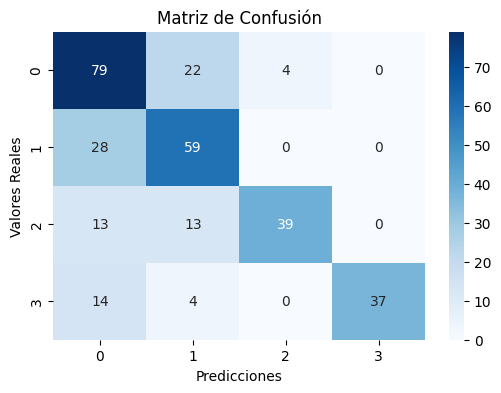

In [41]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

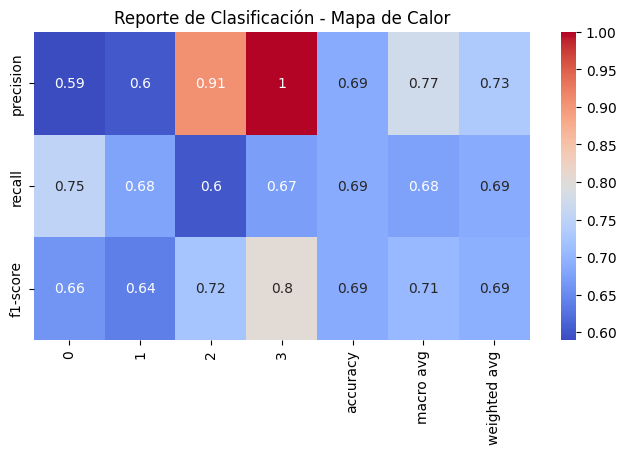

In [42]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [43]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [44]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,207
S,66
V,20


In [45]:
df_results.to_csv('results_SVM_Sentence_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,NR
1,T2_TEST_0002,NR
2,T2_TEST_0003,NR
3,T2_TEST_0004,NR
4,T2_TEST_0005,S


# Clasificación Binaria (Task 1) (RF)

## TD-IDF

### Entrenamiento

In [46]:
X = df_task1['tokens']
y = df_task1['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [47]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Definir el espacio de búsqueda (prefijos según el nombre en el pipeline)
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__max_features': ['sqrt'],
    'rf__class_weight': [None, 'balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}


In [48]:
# Guardar el modelo en un archivo
with open('model_RF_TD-IDF_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [49]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7937964176496286


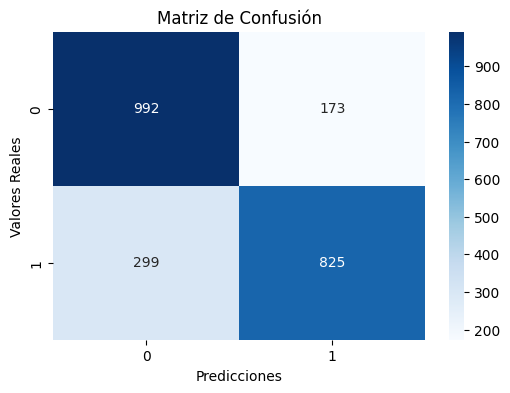

In [50]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

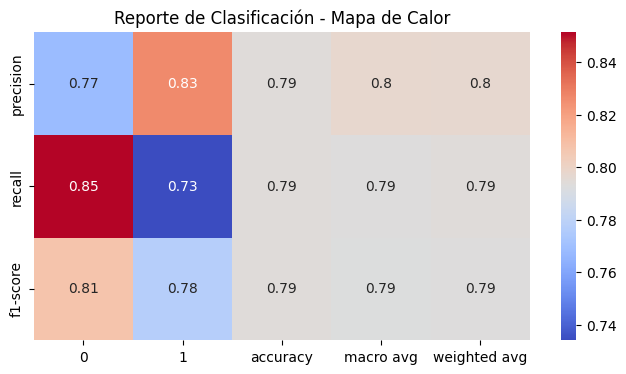

In [51]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [52]:
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [53]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,304
M,223


In [54]:
df_results.to_csv('results_RF_TD-IDF_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,NM
2,T1_TEST_0003,NM
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


## Sentence-Embeddings

In [55]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [56]:
# Generar embeddings para cada texto
lyrics = df_task1['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task1['label']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/358 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [57]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced']
}

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}


In [58]:
# Guardar el modelo en un archivo
with open('model_RF_Sentence_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [59]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7916120576671035


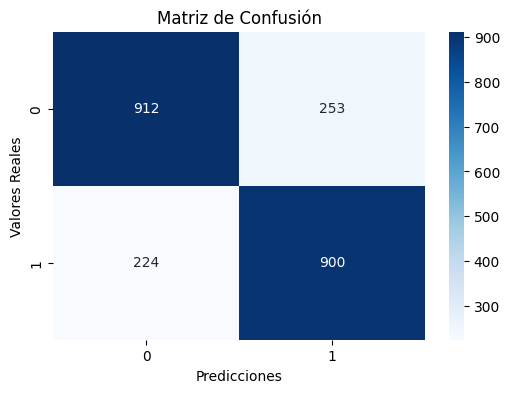

In [60]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

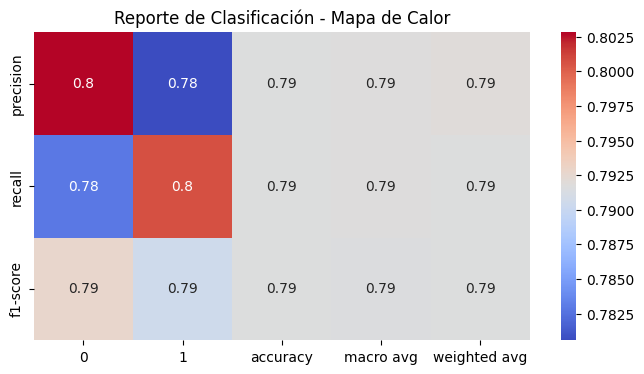

In [61]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [62]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [63]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,512
M,15


In [64]:
df_results.to_csv('results_RF_Sentence_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,NM
2,T1_TEST_0003,NM
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


# Clasificación Multiclase (Task 2) (RF)

## TD-IDF

### Entrenamiento

In [65]:
X = df_task2['tokens']
y = df_task2['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [66]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# Definir el espacio de búsqueda (prefijos según el nombre en el pipeline)
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__max_features': ['sqrt'],
    'rf__class_weight': [None, 'balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
}

# Configurar GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores hiperparámetros: {'rf__class_weight': None, 'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__n_estimators': 200, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 1)}


In [67]:
# Guardar el modelo en un archivo
with open('model_RF_TD-IDF_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [68]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.717948717948718


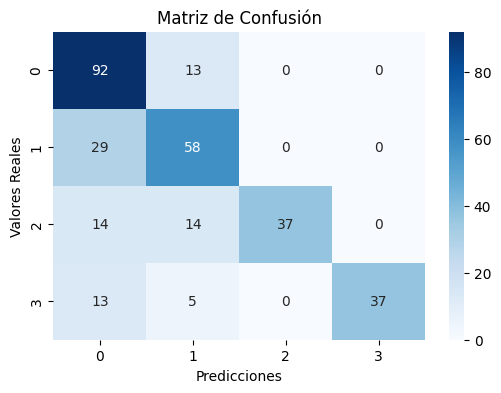

In [69]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

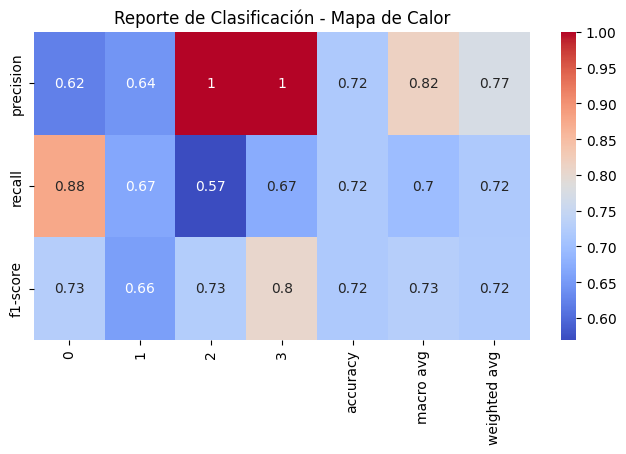

In [70]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [71]:
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [72]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,138
S,82
H,37
V,36


In [73]:
df_results.to_csv('results_RF_TD-IDF_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,NR
1,T2_TEST_0002,NR
2,T2_TEST_0003,S
3,T2_TEST_0004,H
4,T2_TEST_0005,V


## Sentence-Embeddings

In [74]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [75]:
# Generar embeddings para cada texto
lyrics = df_task2['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task2['label']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [76]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'max_features': ['sqrt'],
    'class_weight': [None, 'balanced']
}

# Configurar GridSearchCV con validación cruzada de 5 folds
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Mejores hiperparámetros: {'class_weight': None, 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [77]:
# Guardar el modelo en un archivo
with open('model_RF_Sentence_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [78]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7115384615384616


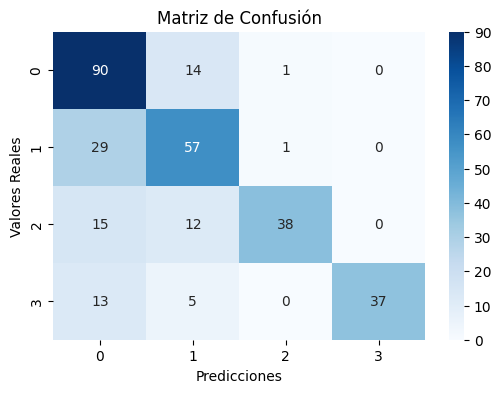

In [79]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

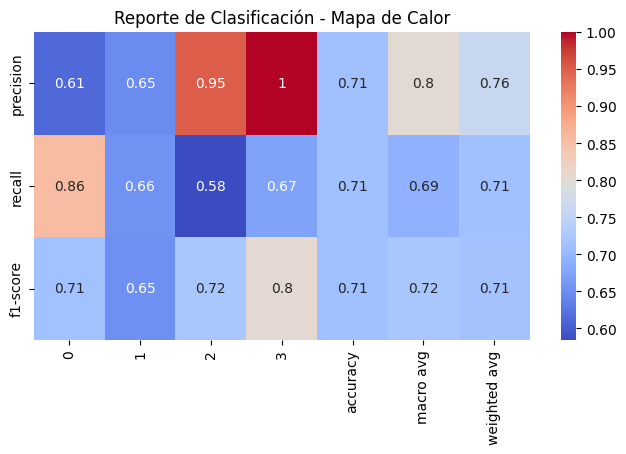

In [80]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [81]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [82]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,293


In [83]:
df_results.to_csv('results_RF_Sentence_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,NR
1,T2_TEST_0002,NR
2,T2_TEST_0003,NR
3,T2_TEST_0004,NR
4,T2_TEST_0005,NR


# Clasificación Binaria (Task 1) (RB)

## TD-IDF

### Entrenamiento

In [84]:
X = df_task1['tokens']
y = df_task1['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [85]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Definir el espacio de búsqueda
param_grid_nb = {
    'nb__alpha': [0.1, 0.5, 1.0],  # Suavizado de Laplace
    'nb__fit_prior': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
}

# Configurar GridSearchCV
grid_search_nb = GridSearchCV(
    pipeline,
    param_grid_nb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)
grid_search_nb.fit(X_train, y_train)

print("Mejores hiperparámetros (NB):", grid_search_nb.best_params_)
best_model = grid_search_nb.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros (NB): {'nb__alpha': 1.0, 'nb__fit_prior': True, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


In [86]:
# Guardar el modelo en un archivo
with open('model_RB_TD-IDF_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [87]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7863695937090432


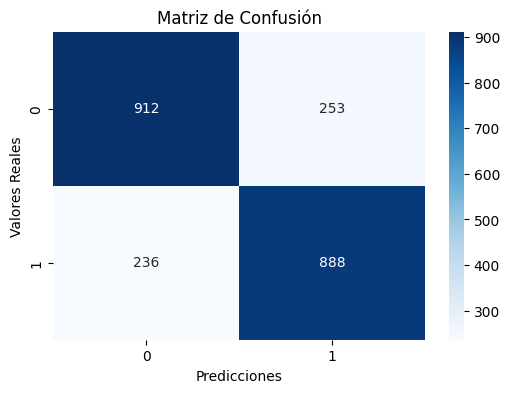

In [88]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

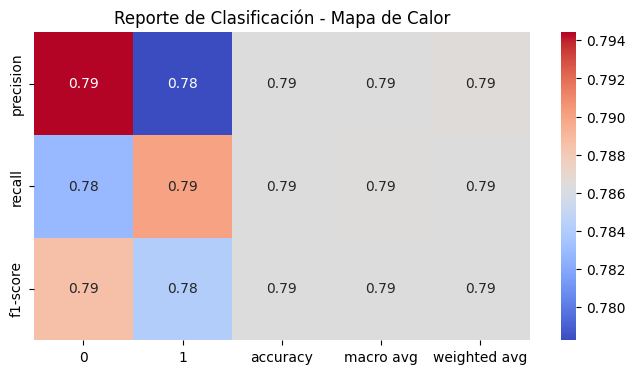

In [89]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [90]:
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [91]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,273
M,254


In [92]:
df_results.to_csv('results_RB_TD-IDF_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,M
2,T1_TEST_0003,NM
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


## Sentence-Embeddings

In [93]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [94]:
# Generar embeddings para cada texto
lyrics = df_task1['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task1['label']
scaler = MinMaxScaler()

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X), y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/358 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


In [95]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],  # suavizado de Laplace
    'fit_prior': [True, False]
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, n_jobs=-1, verbose=2)
grid_search_nb.fit(X_train, y_train)

print("Mejores hiperparámetros (NB):", grid_search_nb.best_params_)
best_model = grid_search_nb.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros (NB): {'alpha': 0.5, 'fit_prior': False}


In [96]:
# Guardar el modelo en un archivo
with open('model_RB_Sentence_task1.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [97]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7339449541284404


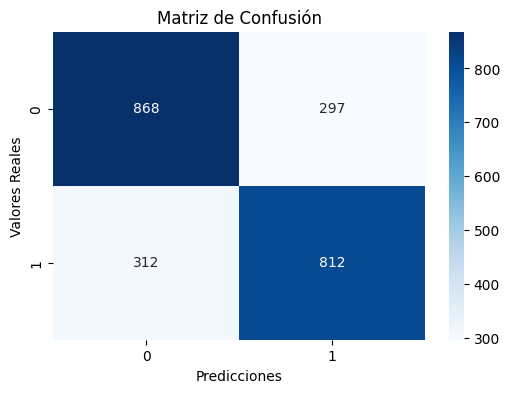

In [98]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

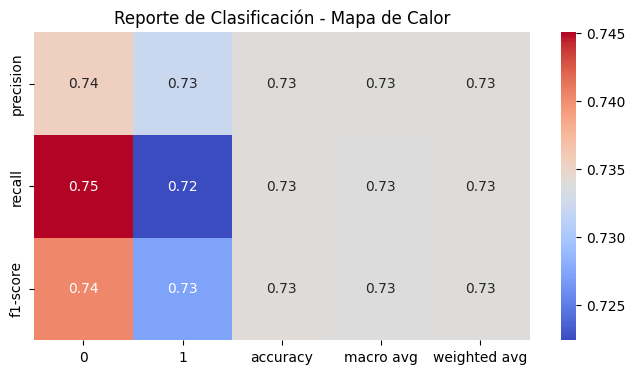

In [99]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [100]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

In [101]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

,count
label,
NM,375
M,152


In [102]:
df_results.to_csv('results_RB_Sentence_task1.csv', index=False)
df_results.head()

,id,label
0,T1_TEST_0001,NM
1,T1_TEST_0002,NM
2,T1_TEST_0003,M
3,T1_TEST_0004,NM
4,T1_TEST_0005,NM


# Clasificación Multiclase (Task 2) (RB)

## TD-IDF

### Entrenamiento

In [103]:
X = df_task2['tokens']
y = df_task2['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [104]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# Definir el espacio de búsqueda
param_grid_nb = {
    'nb__alpha': [0.1, 0.5, 1.0],  # Suavizado de Laplace
    'nb__fit_prior': [True, False],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [1, 5],
}

# Configurar GridSearchCV
grid_search_nb = GridSearchCV(
    pipeline,
    param_grid_nb,
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='f1_macro'
)
grid_search_nb.fit(X_train, y_train)

print("Mejores hiperparámetros (NB):", grid_search_nb.best_params_)
best_model = grid_search_nb.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Mejores hiperparámetros (NB): {'nb__alpha': 0.5, 'nb__fit_prior': True, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}


In [105]:
# Guardar el modelo en un archivo
with open('model_RB_TD-IDF_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [106]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.717948717948718


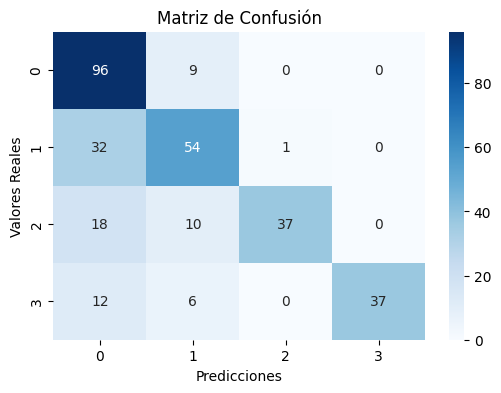

In [107]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

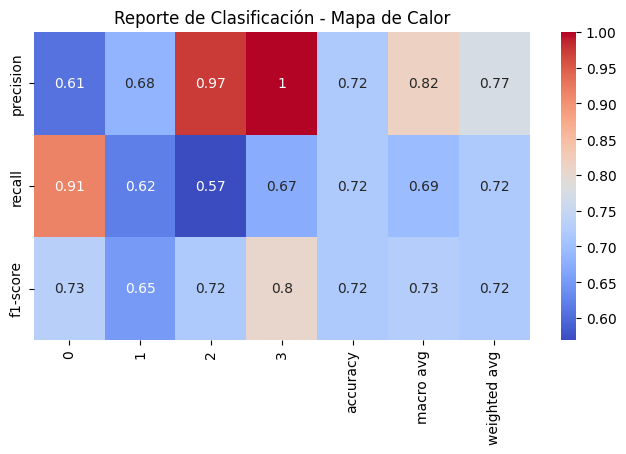

In [108]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [109]:
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = best_model.predict(X_test)

In [110]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,146
S,74
H,37
V,36


In [111]:
df_results.to_csv('results_RB_TD-IDF_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,NR
1,T2_TEST_0002,NR
2,T2_TEST_0003,S
3,T2_TEST_0004,H
4,T2_TEST_0005,V


## Sentence-Embeddings

In [112]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [113]:
# Generar embeddings para cada texto
lyrics = df_task2['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task2['label']
scaler = MinMaxScaler()

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X), y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Batches:   0%|          | 0/49 [00:00<?, ?it/s]

Distribución en Train:
 label
0    0.337881
1    0.279294
2    0.207865
3    0.174960
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.336538
1    0.278846
2    0.208333
3    0.176282
Name: proportion, dtype: float64


In [114]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0],  # suavizado de Laplace
    'fit_prior': [True, False]
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, n_jobs=-1, verbose=2)
grid_search_nb.fit(X_train, y_train)

print("Mejores hiperparámetros (NB):", grid_search_nb.best_params_)
best_model = grid_search_nb.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Mejores hiperparámetros (NB): {'alpha': 0.1, 'fit_prior': False}


In [115]:
# Guardar el modelo en un archivo
with open('model_RB_Sentence_task2.pkl', 'wb') as f:
    pk.dump(best_model, f)

### Evaluación

In [116]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6794871794871795


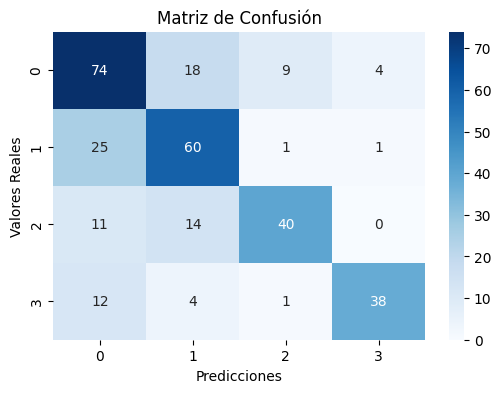

In [117]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

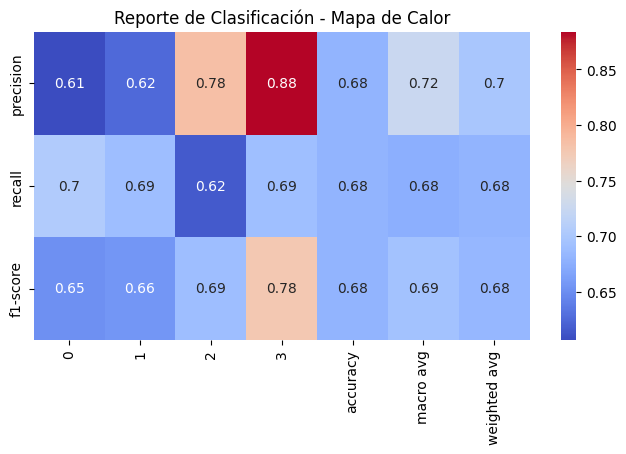

In [118]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [119]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = best_model.predict(X_test)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

In [120]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

,count
label,
NR,148
S,109
V,25
H,11


In [121]:
df_results.to_csv('results_RB_Sentence_task2.csv', index=False)
df_results.head()

,id,label
0,T2_TEST_0001,NR
1,T2_TEST_0002,NR
2,T2_TEST_0003,V
3,T2_TEST_0004,NR
4,T2_TEST_0005,S


# Ensamble (Task 1)

## TD-IDF

### Entrenamiento

In [80]:
X = df_task1['tokens']
y = df_task1['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Distribución en Train:
 label
0    0.508684
1    0.491316
Name: proportion, dtype: float64

Distribución en Test:
 label
0    0.508956
1    0.491044
Name: proportion, dtype: float64


Se construye el ensamble con los 3 anteriores modelos

In [81]:
embedding = 'TD-IDF'
task = 'task1'

# Cargar los modelos ya entrenados
with open(f'model_SVM_{embedding}_{task}.pkl', 'rb') as f:
    model_1 = pk.load(f)

with open(f'model_RF_{embedding}_{task}.pkl', 'rb') as f:
    model_2 = pk.load(f)

with open(f'model_RB_{embedding}_{task}.pkl', 'rb') as f:
    model_3 = pk.load(f)

ensemble = VotingClassifier(
    estimators=[
        ('SVM', model_1),
        ('RF', model_2),
        ('RB', model_3)
    ],
    voting='hard'
)

ensemble.fit(X_train, y_train)

VotingClassifier(estimators=[('SVM',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('svm',
                                               SVC(C=1, class_weight='balanced',
                                                   gamma='auto',
                                                   kernel='linear',
                                                   random_state=42))])),
                             ('RF',
                              Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                              ('rf',
                                               RandomForestClassifier(class_weight='balanced',
                                                                      n_estimators=200,
                                                                      random_state=42))])),
                             ('RB',
                              Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('nb', MultinomialNB())]))],
                 voting='soft')

In [82]:
# Guardar el modelo en un archivo
with open('ensamble_TD-IDF_task1.pkl', 'wb') as f:
    pk.dump(ensemble, f)

### Evaluación

In [83]:
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [ ]:
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = ensemble.predict(X_test)

In [ ]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

In [ ]:
df_results.to_csv('results_ensamble_TD-IDF_task1.csv', index=False)
df_results.head()

## Sentence-Embeddings

In [ ]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [ ]:
# Generar embeddings para cada texto
lyrics = df_task1['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task1['label']
scaler = MinMaxScaler()

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X), y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

In [ ]:
embedding = 'Sentence'
task = 'task1'

# Cargar los modelos ya entrenados
with open(f'model_SVM_{embedding}_{task}.pkl', 'rb') as f:
    model_1 = pk.load(f)

with open(f'model_RF_{embedding}_{task}.pkl', 'rb') as f:
    model_2 = pk.load(f)

with open(f'model_RB_{embedding}_{task}.pkl', 'rb') as f:
    model_3 = pk.load(f)

ensemble = VotingClassifier(
    estimators=[
        ('SVM', model_1),
        ('RF', model_2),
        ('RB', model_3)
    ],
    voting='hard'
)

ensemble.fit(X_train, y_train)

In [ ]:
# Guardar el modelo en un archivo
with open('ensamble_Sentence_task1.pkl', 'wb') as f:
    pk.dump(ensemble, f)

### Evaluación

In [ ]:
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = ensemble.predict(X_test)

In [ ]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NM', 1: 'M'})
df_results['label'].value_counts()

In [ ]:
df_results.to_csv('results_ensamble_Sentence_task1.csv', index=False)
df_results.head()

# Ensamble (Task 2)

## TD-IDF

### Entrenamiento

In [ ]:
X = df_task2['tokens']
y = df_task2['label']  # Etiquetas de clasificación

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Verificar la proporción de clases en train y test
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

Se construye el ensamble con los 3 anteriores modelos

In [ ]:
embedding = 'TD-IDF'
task = 'task2'

# Cargar los modelos ya entrenados
with open(f'model_SVM_{embedding}_{task}.pkl', 'rb') as f:
    model_1 = pk.load(f)

with open(f'model_RF_{embedding}_{task}.pkl', 'rb') as f:
    model_2 = pk.load(f)

with open(f'model_RB_{embedding}_{task}.pkl', 'rb') as f:
    model_3 = pk.load(f)

ensemble = VotingClassifier(
    estimators=[
        ('SVM', model_1),
        ('RF', model_2),
        ('RB', model_3)
    ],
    voting='hard'
)

ensemble.fit(X_train, y_train)

In [ ]:
# Guardar el modelo en un archivo
with open('ensamble_TD-IDF_task2.pkl', 'wb') as f:
    pk.dump(ensemble, f)

### Evaluación

In [ ]:
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [ ]:
df_test = pd.read_csv('track_1_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()
df_test['tokens'] = df_test['lyrics_clean'].astype(str).apply(limpiar_texto)

y_pred = ensemble.predict(X_test)

In [ ]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

In [ ]:
df_results.to_csv('results_ensamble_TD-IDF_task2.csv', index=False)
df_results.head()

## Sentence-Embeddings

In [ ]:
# Cargar modelo preentrenado de sentence embeddings
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

### Entrenamiento

In [ ]:
# Generar embeddings para cada texto
lyrics = df_task2['lyrics_clean'].reset_index(drop=True)
X = model.encode(lyrics, show_progress_bar=True)
y = df_task2['label']
scaler = MinMaxScaler()

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    scaler.fit_transform(X), y, test_size=0.2, stratify=y, random_state=42
)

# Verificar la proporción de clases
print("Distribución en Train:\n", y_train.value_counts(normalize=True))
print("\nDistribución en Test:\n", y_test.value_counts(normalize=True))

In [ ]:
embedding = 'Sentence'
task = 'task2'

# Cargar los modelos ya entrenados
with open(f'model_SVM_{embedding}_{task}.pkl', 'rb') as f:
    model_1 = pk.load(f)

with open(f'model_RF_{embedding}_{task}.pkl', 'rb') as f:
    model_2 = pk.load(f)

with open(f'model_RB_{embedding}_{task}.pkl', 'rb') as f:
    model_3 = pk.load(f)

ensemble = VotingClassifier(
    estimators=[
        ('SVM', model_1),
        ('RF', model_2),
        ('RB', model_3)
    ],
    voting='hard'
)

ensemble.fit(X_train, y_train)

In [ ]:
# Guardar el modelo en un archivo
with open('ensamble_Sentence_task2.pkl', 'wb') as f:
    pk.dump(ensemble, f)

### Evaluación

In [ ]:
y_pred = ensemble.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión como un heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))
plt.xlabel("Predicciones")
plt.ylabel("Valores Reales")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# Obtener el classification report como diccionario
report_dict = classification_report(y_test, y_pred, output_dict=True)

# Convertirlo en DataFrame para graficar
df_report = pd.DataFrame(report_dict)

# Graficar el classification report como un heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :], annot=True, cmap="coolwarm")  # Quitamos el último índice (accuracy global)
plt.title("Reporte de Clasificación - Mapa de Calor")
plt.show()

### Creación de resultados test

In [ ]:
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
df_test = pd.read_csv('track_2_public_test_rev002.csv')
df_test["lyrics_clean"] = df_test["lyrics"].str.replace(r"\[.*?\]", "", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

lyrics = df_test['lyrics_clean'].reset_index(drop=True)
X_test = model.encode(lyrics, show_progress_bar=True)
scaler = MinMaxScaler()
X_test = scaler.fit_transform(X_test)

y_pred = ensemble.predict(X_test)

In [ ]:
df_results = pd.DataFrame([df_test['id'], y_pred], index = ['id', 'label']).T
df_results['label'] = df_results['label'].replace({0: 'NR', 1: 'S', 2: 'V', 3: 'H'})
df_results['label'].value_counts()

In [ ]:
df_results.to_csv('results_ensamble_Sentence_task2.csv', index=False)
df_results.head()

# Final descarga

In [ ]:
import zipfile
import os

zip_filename = 'todo_el_directorio.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk('.'):
        for filename in filenames:
            filepath = os.path.join(foldername, filename)
            # Evitar que se incluya el propio ZIP en la compresión si ya existe
            if filepath != f'./{zip_filename}':
                zipf.write(filepath, arcname=os.path.relpath(filepath, '.'))

In [ ]:
from google.colab import files
files.download(zip_filename)